# Visual Pipelines 

This notebook demonstrates a proof of concept for a visual pipeline for analytics. 

![Yellowbrick Prototype Pipeline Objects](figures/pipeline_prototype.png)

In [1]:
%matplotlib inline

import os
import sys 

# Modify the path 
sys.path.append("..")

import numpy as np
import pandas as pd
import yellowbrick as yb 
import matplotlib as mpl 
import matplotlib.pyplot as plt 

## Load Datasets 

Note that if datasets do not exist, please see the `download.py` located in this directory. 

In [2]:
FIXTURES  = os.path.join(os.getcwd(), "data")
credit    = pd.read_excel(os.path.join(FIXTURES, "credit.xls"), header=1)
concrete  = pd.read_excel(os.path.join(FIXTURES, "concrete.xls"))
occupancy = pd.read_csv(os.path.join('data','occupancy','datatraining.txt'))

In [3]:
# Rename the columns of the datasets for ease of use. 
credit.columns = [
    'id', 'limit', 'sex', 'edu', 'married', 'age', 'apr_delay', 'may_delay',
    'jun_delay', 'jul_delay', 'aug_delay', 'sep_delay', 'apr_bill', 'may_bill',
    'jun_bill', 'jul_bill', 'aug_bill', 'sep_bill', 'apr_pay', 'may_pay', 'jun_pay',
    'jul_pay', 'aug_pay', 'sep_pay', 'default'
]

concrete.columns = [
    'cement', 'slag', 'ash', 'water', 'splast',
    'coarse', 'fine', 'age', 'strength'
]

occupancy.columns = [
    'date', 'temp', 'humid', 'light', 'co2', 'hratio', 'occupied'
]


## Evaluation Visualization Prototype

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class VisualPipeline(Pipeline):
    
    def draw(self):
        """
        Calls the draw method on every visual transformer/estimator  
        """
        for name, estimator in self.steps:
            try:
                estimator.draw()
            except AttributeError:
                continue 

                
class ClassifierEvaluation(object):
    
    def draw(self):
        yb.crplot()

In [5]:
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler 

model = Pipeline([
    ('scale', StandardScaler()), 
    ('model', LinearSVC())
])

model.steps

[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)),
 ('model', LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
       intercept_scaling=1, loss='squared_hinge', max_iter=1000,
       multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
       verbose=0))]

## `Visualizer` class

In base.py at the root of yellowbrick.

In [6]:
class Visualizer(BaseEstimator):
    """
    Base class for feature visualization and model visualization.
    
    Ensures that styling arguments are passed in.
    """
    
    def __init__(self, **kwargs):
        self.size  = kwargs.pop('size')
        self.color = kwargs.pop('color')
        
    def fit(self, X, y=None, **kwargs):
        """
        Fits a transformer to X and y 
        """
        pass
    
    def draw(self, **kwargs):
        pass
    
    def show(self, model=None):
        """
        Visualizes either data features 
        or fitted model scores
        """
        pass
    
    def fitdraw(self, X, y=None):
        """
        Fits a transformer to X and y then returns
        visualization of features or fitted model.
        """
        pass
    

## `FeatureVisualizer` base class

Comes between or at the end of transformers but before the estimator. 

In [7]:
class FeatureVisualizer(Visualizer, TransformerMixin):
    """
    Base class for feature visualization to investigate features 
    individually or together.
    
    FeatureVisualizer is itself a transformer so that it can be used in
    a Scikit-Learn Pipeline to perform automatic visual analysis during build.
    
    Accepts as input a DataFrame or Numpy array.
    """    
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None, **kwargs):
        pass
    
    def transform(self, X):
        pass
    
    def show(self, data=None):
        """
        Visualize data features individually or together
        """
        pass
    
    def fitdraw(self, X, data=None):
        pass
    
    def fit_transform(self, X, data=None):
        pass

## `ScoreVisualizer` class for estimators

Base class to follow an estimator in a pipeline. Not a transformer. 

In [8]:
class ScoreVisualizer(Visualizer):
    """
    Base class to follow an estimator in a visual pipeline.
    
    Draws the score for the fitted model.
    """
    
    def __init__(self, model):
        pass
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        pass
    
    def score(self, y, y_pred=None):
        """
        Score will call draw to visualize model performance.
        If y_pred is None, call fit-predict on the model to get a y_pred.
        """
        return self.draw(y,y_pred)

    def draw(self, X, y):
        pass 
    
    def show(self, **kwargs):
        """
        The user calls show
        """
        pass



In [9]:
from yellowbrick.colors import ddlheatmap
from yellowbrick.exceptions import YellowbrickTypeError
from yellowbrick.utils import get_model_name, isestimator, isclassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_fscore_support

class ClassificationScoreVisualizer(ScoreVisualizer):
    
    def __init__(self, model):
        """
        Check to see if model is an instance of a classifer.
        Should return a metrics mismatch error if it isn't.
        """
        if not isclassifier(model):
            raise YellowbrickTypeError(
                "This estimator is not a classifier; try a regression or clustering score visualizer instead!"
        )

class ROCAUC(ClassificationScoreVisualizer):
    """
    Plot the ROC to visualize the tradeoff between the classifier's
    sensitivity and specificity.
    """
    def __init__(self, model, **kwargs):
        """
        Pass in a model to generate a ROC curve.
        """
        self.estimator = model
        self.name = get_model_name(self.estimator)
        super(ROCAUC, self).__init__(model, **kwargs)
        self.colors = {
            'roc': kwargs.pop('roc_color', '#2B94E9'),
            'diagonal': kwargs.pop('diagonal_color', '#666666'),
        }
        plt.figure()  # save to object?
        
    def fit(self):
        pass
    
    def predict(self):
        pass
    
    def score(self, y, y_pred=None):
        self.fpr, self.tpr, self.thresholds = roc_curve(y, y_pred)
        self.roc_auc = auc(self.fpr, self.tpr)
        self.draw(y, y_pred)
        
    def draw(self, y, y_pred): # don't need y and y_pred here
        """
        Renders ROC-AUC plot.
        Called internally by score, possibly more than once
        """  
        plt.plot(self.fpr, self.tpr, c=self.colors['roc'], label='AUC = {:0.2f}'.format(self.roc_auc))

        # Plot the line of no discrimination to compare the curve to.
        plt.plot([0,1],[0,1],'m--',c=self.colors['diagonal'])


    def show(self, **kwargs):
        """        
        Called by user.
        
        Only takes self.
        
        Take in the model as input and generates a plot of
        the ROC plots with AUC metrics embedded.
        """
        plt.title('ROC for {}'.format(self.name))
        plt.legend(loc='lower right')

        plt.xlim([-0.02,1])
        plt.ylim([0,1.1])

        return plt

class ClassificationReport(ClassificationScoreVisualizer):
    """
    Classification report that shows the precision, recall, and F1 scores
    for the model. Integrates numerical scores as well color-coded heatmap.
    """
    def __init__(self, model, **kwargs):
        """
        Pass in a fitted model to generate a ROC curve.
        """
        self.estimator = model
        self.name = get_model_name(self.estimator)
        self.cmap = kwargs.pop('cmap', ddlheatmap)
        self.classes = model.classes_

        
    def score(self, y, y_pred=None, **kwargs):
        """
        Generates the Scikit-Learn classification_report
        """
        self.keys = ('precision', 'recall', 'f1')
        self.scores = precision_recall_fscore_support(y, y_pred, labels=self.classes)
        self.scores = map(lambda s: dict(zip(self.classes, s)), self.scores[0:3])
        self.scores = dict(zip(self.keys, self.scores))  
        self.draw(y, y_pred)

        
    def draw(self, y, y_pred):
        """
        Renders the classification report across each axis.
        """        
        fig, ax = plt.subplots(1)

        self.matrix = []
        for cls in self.classes:
            self.matrix.append([self.scores['precision'][cls],self.scores['recall'][cls],self.scores['f1'][cls]])
       
        for column in range(len(self.matrix)+1):
            for row in range(len(self.classes)):   
                ax.text(column,row,self.matrix[row][column],va='center',ha='center')

        fig = plt.imshow(self.matrix, interpolation='nearest', cmap=self.cmap)
        return ax


    def show(self):
        """
        Plots a classification report as a heatmap.
        """
        plt.title('{} Classification Report'.format(self.name))
        plt.colorbar()
        x_tick_marks = np.arange(len(self.classes)+1)
        y_tick_marks = np.arange(len(self.classes))
        plt.xticks(x_tick_marks, ['precision', 'recall', 'f1-score'], rotation=45)
        plt.yticks(y_tick_marks, self.classes)
        plt.ylabel('Classes')
        plt.xlabel('Measures')

        return plt

In [10]:
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

X = occupancy[['temp','humid','light','co2','hratio']]
y = occupancy['occupied']

In [11]:
## Throw an error if the model isn't a classifier!
# model = LinearRegression()
# model.fit(X,y)
# y_pred = model.predict(X)
# sviz = ROCAUC(model)

In [12]:
model = LinearSVC()
model.fit(X,y)
y_pred = model.predict(X)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

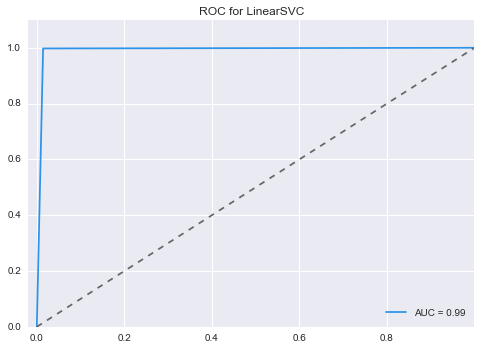

In [13]:
sviz = ROCAUC(model)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

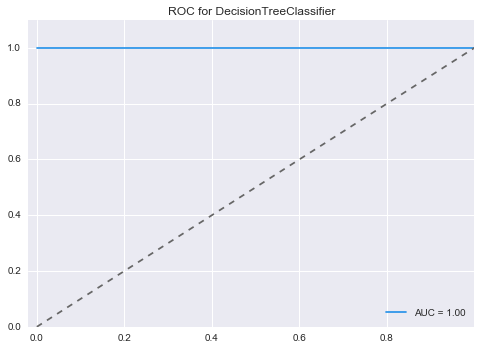

In [14]:
model = DecisionTreeClassifier()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ROCAUC(model)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

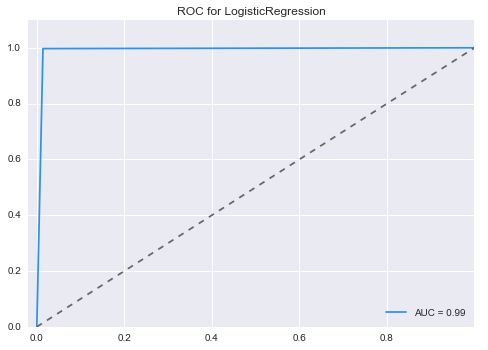

In [15]:
model = LogisticRegression()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ROCAUC(model)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

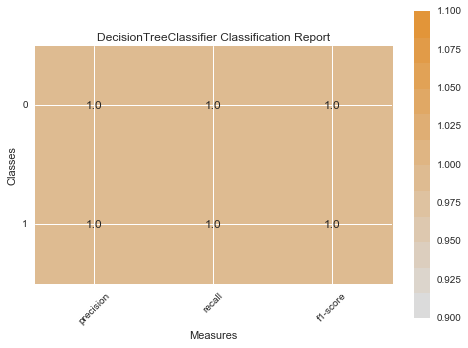

In [16]:
model = DecisionTreeClassifier()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassificationReport(model)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

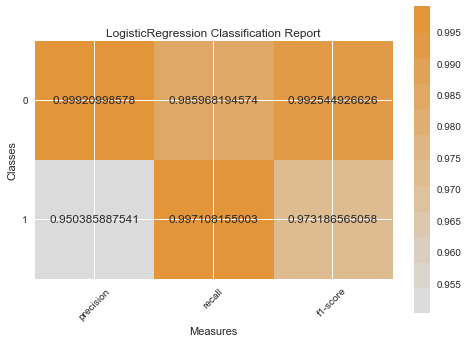

In [17]:
model = LogisticRegression()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassificationReport(model)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

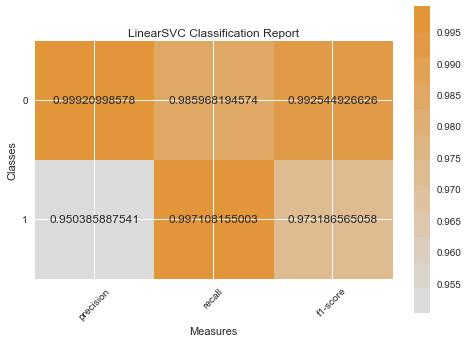

In [18]:
model = LinearSVC()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassificationReport(model)
sviz.score(y,y_pred)
sviz.show() 

In [19]:
from yellowbrick.bestfit import draw_best_fit

class RegressionScoreVisualizer(ScoreVisualizer):
    def __init__(self, model):
        """
        Check to see if model is an instance of a regressor.
        Should return a metrics mismatch error if it isn't.
        """
        pass
    
class PredictionError(RegressionScoreVisualizer):
    """
    Plot the actual targets from the dataset against the 
    predicted values generated by our model(s).
    """
    def __init__(self, model, **kwargs):
        self.estimator = model
        self.name = get_model_name(self.estimator)
        self.colors = {
            'point': kwargs.pop('point_color', '#F2BE2C'),
            'line': kwargs.pop('line_color', '#2B94E9'),
        }
        self.fig, self.ax = plt.subplots()
        
    def score(self, y, y_pred=None, **kwargs):
        """
        Originally score  for prediction error was conceived as generating
        y_pred by calling the sklearn function cross_val_predict on the 
        model, X, y, and the specified number of folds, e.g.:
        
            y_pred = cv.cross_val_predict(model, X, y, cv=12)
        
        With the new API, there's not much for score to do.
        
        """
        self.draw(y,y_pred)
        
    def draw(self, y, y_pred):
        """
        If score is happening inside a loop, draw would get called multiple times.
        
        But, ideally we'd want the best fit line to be drawn only once?
        """
        self.ax.scatter(y, y_pred, c='#F2BE2C')
        draw_best_fit(y, y_pred, self.ax, 'linear', ls='--', lw=2, c=self.colors['line'])
        return self.ax
    
    def show(self):
        self.ax.set_xlim(y.min()-1, y.max()+1)
        self.ax.set_ylim(y_pred.min()-1, y_pred.max()+1)
        self.ax.set_title('Prediction Error for {}'.format(self.name))
        self.ax.set_ylabel('Predicted')
        plt.xlabel('Measured')
        return plt


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

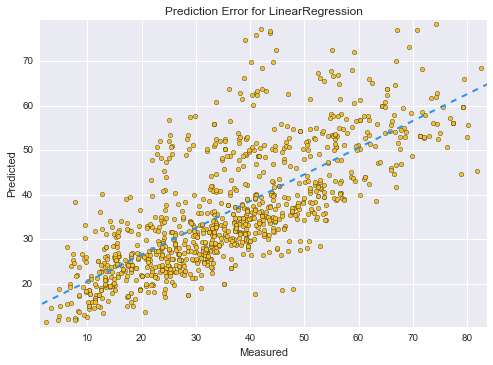

In [20]:
from sklearn.linear_model import LinearRegression, Ridge, RANSACRegressor 
from sklearn import cross_validation as cv

X = concrete[['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']]
y = concrete['strength']

model = LinearRegression()
model.fit(X,y)
sviz = PredictionError(model)
y_pred = cv.cross_val_predict(model, X, y, cv=12)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

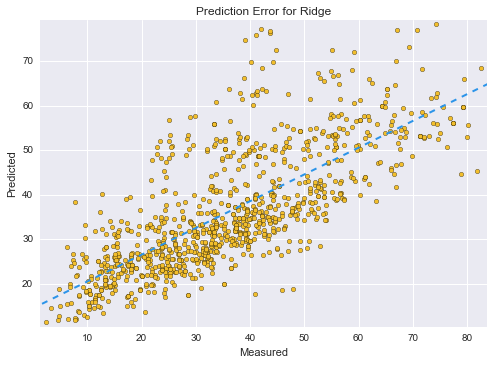

In [21]:
model = Ridge()
model.fit(X,y)
sviz = PredictionError(model)
y_pred = cv.cross_val_predict(model, X, y, cv=12)
sviz.score(y,y_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

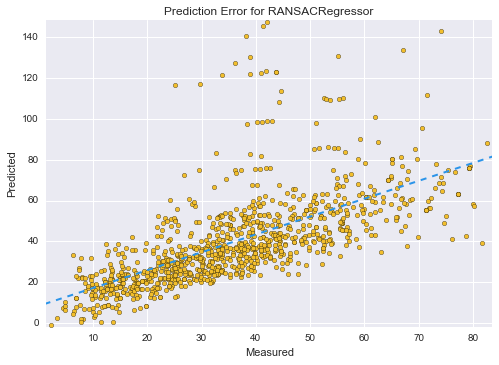

In [22]:
model = RANSACRegressor()
model.fit(X,y)
sviz = PredictionError(model)
y_pred = cv.cross_val_predict(model, X, y, cv=12)
sviz.score(y,y_pred)
sviz.show() 

In [23]:
class ResidualsPlot(RegressionScoreVisualizer):
    def __init__(self, model, **kwargs):
        self.estimator = model
        self.name = get_model_name(self.estimator)
        self.colors = {
            'train_point': kwargs.pop('train_point_color', '#2B94E9'),
            'test_point': kwargs.pop('test_point_color', '#94BA65'),
            'line': kwargs.pop('line_color', '#333333'),
        }
        self.fig, self.ax = plt.subplots()
        
    def score(self, y, y_pred, y_test=None, y_test_pred=None):
        """
        Is there a better way to differentiate between train and test points?
        
        We'd like to color them differently in draw...       
        Can the user pass those in as keyword arguments?
        """
        self.draw(y, y_pred, y_test, y_test_pred)
        
    def draw(self, y, y_pred, y_test, y_test_pred):
        self.ax.scatter(y_pred, y_pred - y, c=self.colors['train_point'], s=40, alpha=0.5)
        if y_test is not None:
            self.ax.scatter(y_test, y_test_pred - y_test, c=self.colors['test_point'], s=40)
        else:
            pass
        
        return self.ax

    def show(self):
        """
        The user calls show
        """
        self.ax.hlines(y=0, xmin=0, xmax=100)
        self.ax.set_title('Residuals for {} Model'.format(self.name))
        self.ax.set_ylabel('Residuals')
        plt.xlabel("Predicted Value")
        
        return plt
   

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

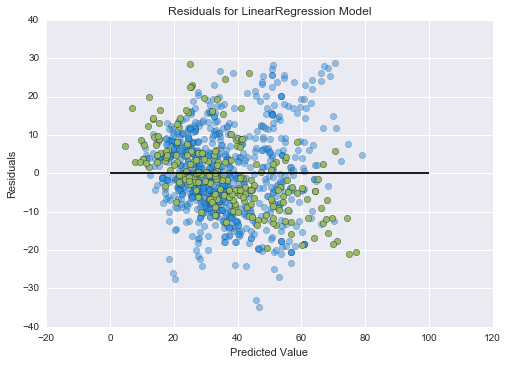

In [24]:
from sklearn.model_selection import train_test_split as tts

model = LinearRegression()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
sviz = ResidualsPlot(model)
sviz.score(y_train, y_train_pred,y_test, y_test_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

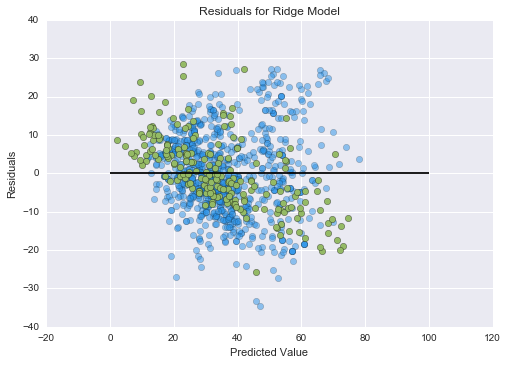

In [25]:
model = Ridge()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
sviz = ResidualsPlot(model)
sviz.score(y_train, y_train_pred,y_test, y_test_pred)
sviz.show() 

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/pyplot.py'>

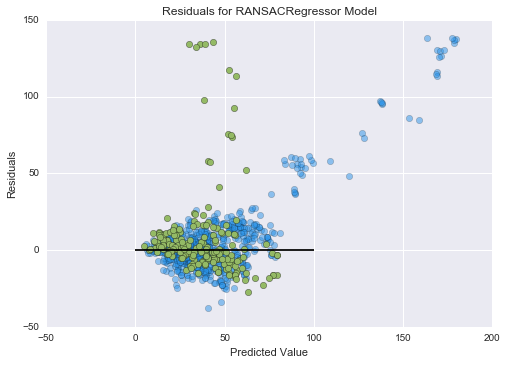

In [26]:
model = RANSACRegressor()
X_train, X_test, y_train, y_test = tts(X, y, test_size=0.2)
model.fit(X_train,y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)
sviz = ResidualsPlot(model)
sviz.score(y_train, y_train_pred,y_test, y_test_pred)
sviz.show() 

In [27]:
from yellowbrick.yb_palettes import YELLOWBRICK_PALETTES

class ClassBalance(ClassificationScoreVisualizer):
    """
    Class balance chart that shows the support for each class in the
    fitted classification model.
    """
    def __init__(self, model, **kwargs):
        """
        Pass in a fitted model to generate a class balance chart.
        """
        self.estimator = model
        self.name      = get_model_name(self.estimator)
        self.colors    = kwargs.pop('colors', YELLOWBRICK_PALETTES['paired'])
        self.classes   = model.classes_

    def score(self, y, y_pred=None, **kwargs):
        """
        Generates the Scikit-Learn precision_recall_fscore_support
        """
        self.scores  = precision_recall_fscore_support(y, y_pred, labels=self.classes)
        self.support = dict(zip(self.classes, self.scores[-1])  )
        self.draw()

    def draw(self):
        """
        Renders the class balance chart across the axis.
        
        TODO: Would rather not have to set the colors with this method. 
        Refactor to make better use of yb_palettes module?
        
        """
        colors = self.colors[0:len(self.classes)]
        plt.bar(np.arange(len(self.support)), self.support.values(), color=colors, align='center', width=0.5)

    def show(self):
        """
        Plots a class balance chart
        """
        plt.xticks(np.arange(len(self.support)), self.support.keys())
        cmax, cmin = max(self.support.values()), min(self.support.values())
        ceiling = cmax + cmax*0.1
        span = cmax - cmin
        plt.ylim(0, ceiling)
        plt.show()


In [28]:
X = credit[['limit', 'sex', 'edu', 'married', 'age', 'apr_delay', 'may_delay',
    'jun_delay', 'jul_delay', 'aug_delay', 'sep_delay', 'apr_bill', 'may_bill',
    'jun_bill', 'jul_bill', 'aug_bill', 'sep_bill', 'apr_pay', 'may_pay', 'jun_pay',
    'jul_pay', 'aug_pay', 'sep_pay']]
y = credit['default']

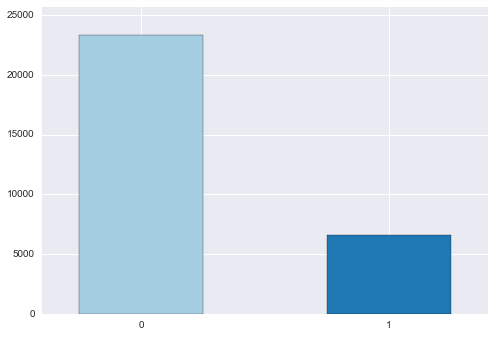

In [29]:
model = LinearSVC()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassBalance(model)
sviz.score(y,y_pred)
sviz.show() 

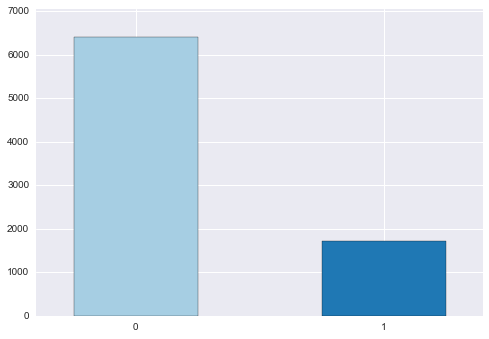

In [30]:
X = occupancy[['temp','humid','light','co2','hratio']]
y = occupancy['occupied']

model = LinearSVC()
model.fit(X,y)
y_pred = model.predict(X)
sviz = ClassBalance(model)
sviz.score(y,y_pred)
sviz.show() 